# Tutorial: IMU Gesture Recognition Model for Edge Devices

This notebook walks through the complete process of building, training, and deploying a machine learning model to recognize gestures from IMU (Inertial Measurement Unit) sensor data.

**The end-to-end workflow is as follows:**
1. **Load and Explore Data**: We will load the provided CSV files containing accelerometer and gyroscope data for different gestures.
2. **Preprocess the Data**: We will prepare the raw time-series data for training by scaling it and creating fixed-length sequences.
3. **Build a 1D CNN Model**: We will construct a 1D Convolutional Neural Network (CNN), which is highly effective for analyzing patterns in sensor data over time.
4. **Train and Evaluate**: We will train the model on our data and then evaluate its performance on a held-out test set.
5. **Convert to TensorFlow Lite**: The trained model will be converted into the TensorFlow Lite format, which is optimized for performance on resource-constrained devices like microcontrollers.
6. **Generate C Header File**: Finally, we will convert the TFLite model into a C byte array and save it as a header file (`.h`) that can be directly included in an embedded project (e.g., Arduino).

### Step 0: Setup and Imports

First, we import all the necessary libraries. We'll need `pandas` for data manipulation, `numpy` for numerical operations, `matplotlib` and `seaborn` for plotting, `scikit-learn` for preprocessing and evaluation, and `tensorflow` for building and training our model.

In [37]:
!pip install pandas "tensorflow==2.19.0" scikit-learn matplotlib seaborn jupyterlab gdown

In [38]:
!gdown --folder https://drive.google.com/drive/folders/1eYGUfByTymbLqHJibcNlxix7ti78KR_d?usp=drive_link

Retrieving folder contents
Processing file 1L7fXskfHsUaSmyGLsDprqiRgw702R7qy imu-circle-2025-09-19_15-13-56.csv
Processing file 1ldNwhFQNwQZL4FMqdgC4knbSzmNRBjH- imu-null-2025-09-19_15-21-42.csv
Processing file 1fCNdLQVSffOP8Gg9rvZZCJHKuR_cR-GC imu-rightleft-2025-09-19_15-18-22.csv
Processing file 1z60lwwJ8Hekf16y79A6BMtEX811kYDO9 imu-updown-2025-09-19_15-17-00.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1L7fXskfHsUaSmyGLsDprqiRgw702R7qy
To: /content/data/imu-circle-2025-09-19_15-13-56.csv
100% 585k/585k [00:00<00:00, 50.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ldNwhFQNwQZL4FMqdgC4knbSzmNRBjH-
To: /content/data/imu-null-2025-09-19_15-21-42.csv
100% 1.07M/1.07M [00:00<00:00, 41.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fCNdLQVSffOP8Gg9rvZZCJHKuR_cR-GC
To: /content/data/imu-rightleft-2025-09-19_15-18-22.csv
100% 754k/754k [00:00<00:00, 

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Step 1: Data Loading and Merging

We have multiple CSV files. We'll use Python's `glob` library to find all files matching the `input_file_*.csv` pattern and then load and concatenate them into a single pandas DataFrame.

In [40]:
csv_files = glob.glob('data/*.csv')
df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

print(f"Loaded {len(csv_files)} files with a total of {len(df)} rows.")
print("First 5 rows of the combined data:")
df.head()

Loaded 4 files with a total of 23511 rows.
First 5 rows of the combined data:


,timestamp,label,ax,ay,az,gx,gy,gz
0,1758295215538,NaN,0.038826,-0.012384,-0.080822,0.994873,0.537109,1.834106
1,1758295215545,NaN,0.037241,-0.012158,-0.078358,0.628662,0.476074,1.834106
2,1758295215551,NaN,0.036527,-0.012618,-0.082266,-0.897217,0.720215,1.834106
3,1758295215568,NaN,0.036616,-0.013755,-0.080206,-0.103760,0.598145,1.589966
4,1758295215574,NaN,0.033905,-0.011617,-0.075082,0.872803,0.476074,1.834106


### Step 2: Data Exploration and Visualization

Before we build a model, it's crucial to understand our data. We will check for missing values, look at the distribution of our gesture labels, and visualize the sensor readings for each gesture.

Missing values check:
timestamp       0
label        8287
ax              0
ay              0
az              0
gx              0
gy              0
gz              0
dtype: int64

Label distribution:
label
rightleft    5561
updown       5147
circle       4516
Name: count, dtype: int64


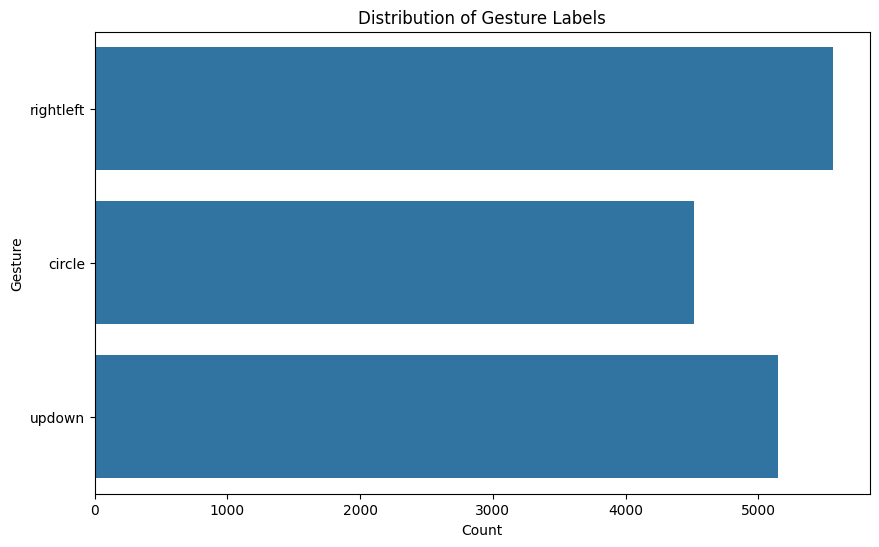

In [41]:
# Check for missing values
print("Missing values check:")
print(df.isnull().sum())

# Check the distribution of labels
print("\nLabel distribution:")
print(df['label'].value_counts())

# Plot the label distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=df['label'])
plt.title('Distribution of Gesture Labels')
plt.xlabel('Count')
plt.ylabel('Gesture')
plt.show()

Now, let's visualize the sensor data for a sample of each gesture. This helps us see if there are clear, distinguishable patterns that a model might be able to learn.

No data found for label: nan


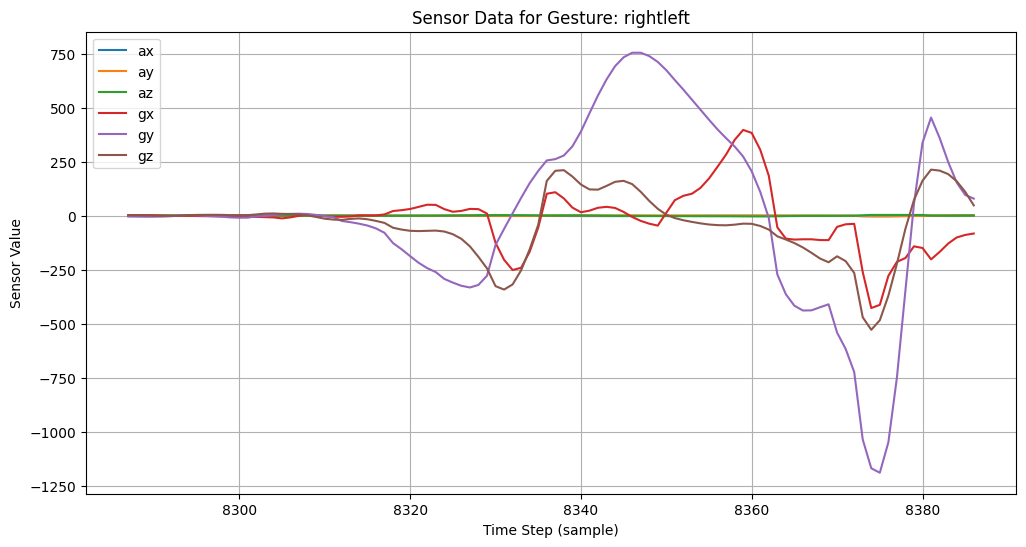

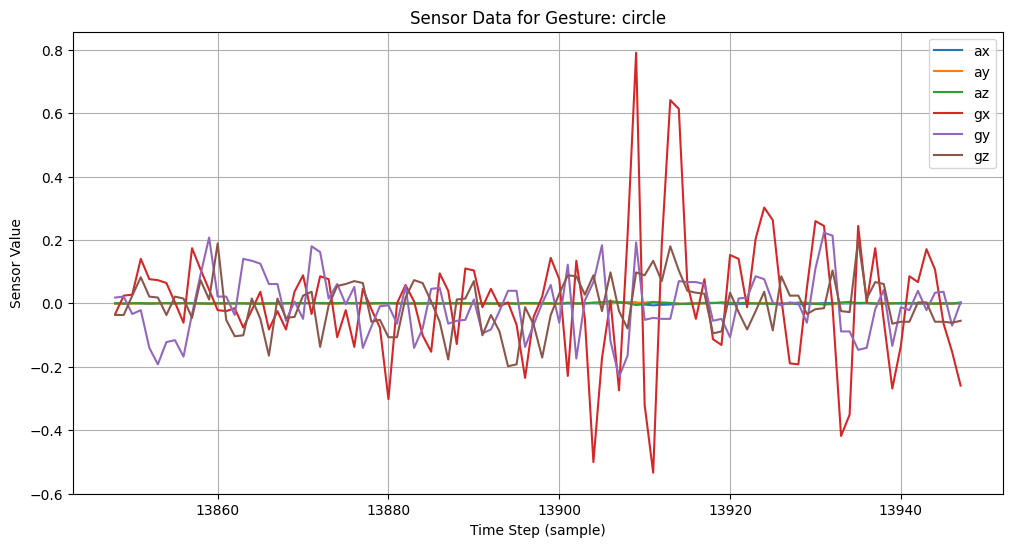

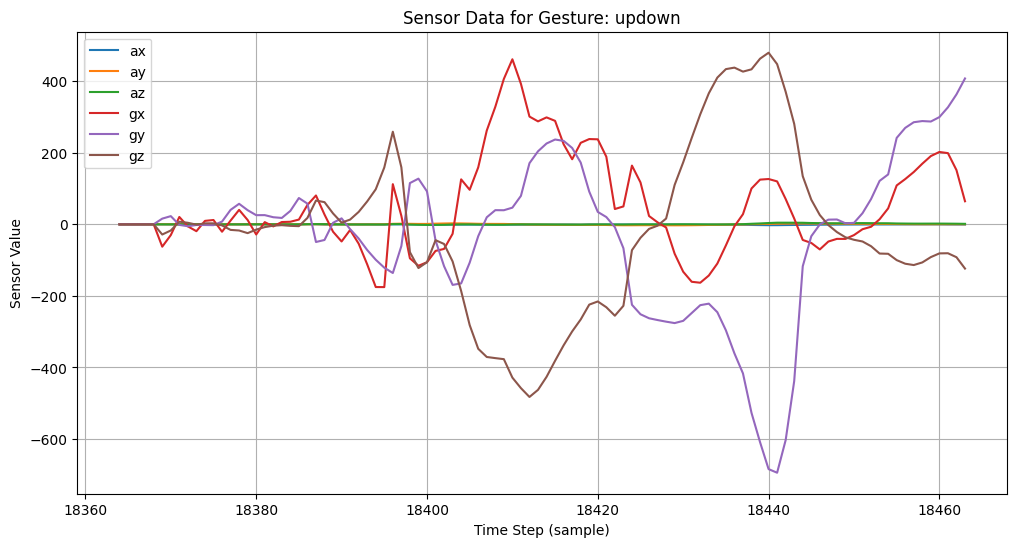

In [42]:
def plot_gesture(label, df):
    """Plots the sensor data for the first occurrence of a given label."""
    gesture_data = df[df['label'] == label].head(100) # Plot first 100 samples
    if gesture_data.empty:
        print(f"No data found for label: {label}")
        return

    plt.figure(figsize=(12, 6))
    sensor_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

    for col in sensor_cols:
        sns.lineplot(x=gesture_data.index, y=gesture_data[col], label=col)

    plt.title(f'Sensor Data for Gesture: {label}')
    plt.xlabel('Time Step (sample)')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot one example of each unique gesture
for label in df['label'].unique():
    plot_gesture(label, df)

### Step 3: Data Preprocessing for Time-Series ML

Machine learning models require numerical input. We need to perform several preprocessing steps:

1.  **Label Encoding**: Convert the string labels (`'circle'`, `'updown'`, etc.) into integers (0, 1, 2...).
2.  **Feature Scaling**: Normalize the sensor data. Neural networks train more effectively when input features are on a similar scale. We'll use `StandardScaler`, which standardizes features by removing the mean and scaling to unit variance.
3.  **Windowing (Creating Sequences)**: This is the most critical step for time-series data. Instead of feeding the model one row at a time, we'll feed it a sequence (or "window") of consecutive rows. This allows the model to learn patterns over time. We will create sequences of a fixed length.

In [43]:
# 1. Label Encoding
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Store the mapping for later
label_mapping = {i: l for i, l in enumerate(label_encoder.classes_)}
print("Label Mapping:", label_mapping)

# 2. Feature Scaling
feature_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

print("\nData after scaling (first 5 rows):")
df.head()

Label Mapping: {0: 'circle', 1: 'rightleft', 2: 'updown', 3: nan}

Data after scaling (first 5 rows):


,timestamp,label,ax,ay,az,gx,gy,gz,label_encoded
0,1758295215538,NaN,0.093603,-0.022262,-0.092292,-0.112650,-0.013420,0.017974,3
1,1758295215545,NaN,0.089920,-0.021934,-0.089636,-0.117027,-0.013818,0.017974,3
2,1758295215551,NaN,0.088260,-0.022603,-0.093849,-0.135266,-0.012229,0.017974,3
3,1758295215568,NaN,0.088467,-0.024253,-0.091629,-0.125782,-0.013023,0.015948,3
4,1758295215574,NaN,0.082165,-0.021149,-0.086103,-0.114109,-0.013818,0.017974,3


In [44]:
# 3. Windowing (Creating Sequences)

SEQUENCE_LENGTH = 50  # Number of time steps in each sequence
STEP = 10             # How many steps to move forward to create the next sequence

def create_sequences(df, seq_length, step, feature_cols, label_col):
    """Creates sequences from the dataframe."""
    sequences = []
    labels = []
    for i in range(0, len(df) - seq_length, step):
        # Extract a chunk of data
        data_chunk = df[feature_cols].iloc[i: i + seq_length]

        # The label for a sequence is the most frequent label in that window
        label_chunk = df[label_col].iloc[i: i + seq_length]
        label = label_chunk.mode()[0] # Take the mode (most common element)

        sequences.append(data_chunk.values)
        labels.append(label)

    return np.array(sequences), np.array(labels)

X, y = create_sequences(df, SEQUENCE_LENGTH, STEP, feature_cols, 'label_encoded')

print(f"Created {len(X)} sequences.")
print(f"Shape of X (sequences): {X.shape}")
print(f"Shape of y (labels): {y.shape}")

Created 2347 sequences.
Shape of X (sequences): (2347, 50, 6)
Shape of y (labels): (2347,)


### Step 4: Splitting the Data

Now we split our sequenced data into training and testing sets. The training set is used to train the model, while the testing set is held back to evaluate its performance on unseen data.

In [54]:
# Split the data into training and test sets (80% train, 20% test)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

print(f"New shape of X (input data): {X.shape}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

New shape of X (input data): (2347, 50, 6, 1)
X_train shape: (1877, 50, 6, 1)
X_test shape: (470, 50, 6, 1)
y_train shape: (1877,)
y_test shape: (470,)


### Step 5: Building the 2D CNN Model

We'll build a simple but effective 2D Convolutional Neural Network. Here's a breakdown of the layers:

### Feature Extraction Block 1
The first two convolutional blocks are the "feature extractors." Their job is to analyze the input "image" and detect meaningful patterns, transforming the raw data into a higher-level representation.

#### 1. `Conv2D(filters=16, kernel_size=(3, 3), ...)`
- **What it does**: This layer applies 16 different filters (or kernels) to the input. Each filter is a tiny `3x3` matrix of weights that is trained to detect a specific, simple pattern (e.g., a rising edge in acceleration, a specific gyroscope interaction, etc.). It slides this `3x3` window across our entire `50x6` input.
- **`filters=16`**: This means the layer will learn 16 distinct patterns and produce 16 new feature maps as its output.
- **`activation='relu'`**: The Rectified Linear Unit introduces non-linearity, allowing the model to learn more complex relationships than simple linear combinations.
- **`padding='same'`**: This ensures the output feature maps have the same height and width as the input (`50x6`).
- **Data Shape Change**: `(50, 6, 1)` -> `(50, 6, 16)`

#### 2. `MaxPooling2D(pool_size=(2, 2))`
- **What it does**: This layer performs downsampling. It looks at `2x2` sections of each feature map and keeps only the maximum value.
- **Purpose**: This makes the model more robust by providing a degree of *translational invariance* (it doesn't matter if a pattern appears slightly higher, lower, left, or right). It also drastically reduces the amount of data, making the network faster and more memory-efficient.
- **Data Shape Change**: The height and width are roughly halved. `(50, 6, 16)` -> `(25, 3, 16)`

#### 3. `Dropout(0.2)`
- **What it does**: During training, this layer randomly sets 20% of the input neurons to zero. This prevents the model from becoming too reliant on any single neuron and helps it generalize better to new, unseen data (prevents overfitting).

In [57]:
num_classes = len(label_mapping)
num_features = len(feature_cols)
input_shape = (SEQUENCE_LENGTH, num_features)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, Dense, Dropout


num_classes = len(label_mapping)
# Our input shape is now 3D: (height, width, channels)
input_shape = (SEQUENCE_LENGTH, num_features, 1)

model = Sequential([
    # Input layer with the new shape
    tf.keras.Input(shape=input_shape),

    # First 2D Convolutional Layer. The kernel will slide over our 50x6 "image".
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    # Dropout is a training-only feature and doesn't become a TFLite operator.
    Dropout(0.2),

    # Second 2D Convolutional Layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Flattening using a Reshape layer, since Flatten is not available.
    # The '-1' tells Keras to automatically calculate the size of the flattened dimension.
    Reshape((-1,)),

    # Dense classifier layers
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Final output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 50, 6, 16)      │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 3, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 25, 3, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 3, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 12, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,700 (116.02 KB)

 Trainable params: 29,700 (116.02 KB)

 Non-trainable params: 0 (0.00 B)

### Step 6: Training the Model

Now we train the model using the `fit` method. We'll train for a set number of `epochs` (passes through the entire training dataset) and use a `validation_split` to monitor performance on a portion of the training data. This helps us see if the model is overfitting.

In [58]:
EPOCHS = 20
BATCH_SIZE = 32

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2, # Use 20% of training data for validation
    verbose=1
)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3881 - loss: 1.3194 - val_accuracy: 0.7739 - val_loss: 0.9347
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7485 - loss: 0.8264 - val_accuracy: 0.9335 - val_loss: 0.3040
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8708 - loss: 0.4215 - val_accuracy: 0.9628 - val_loss: 0.1897
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9212 - loss: 0.2725 - val_accuracy: 0.9734 - val_loss: 0.1433
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9433 - loss: 0.2184 - val_accuracy: 0.9734 - val_loss: 0.1223
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9557 - loss: 0.1755 - val_accuracy: 0.9787 - val_loss: 0.1021
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9683 - loss: 0.1361 - val_accuracy: 0.9761 - val_loss: 0.0956
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9740 - loss: 0.1188 - val_accuracy: 0.9787 - v

Let's visualize the training process to see how accuracy and loss changed over the epochs.

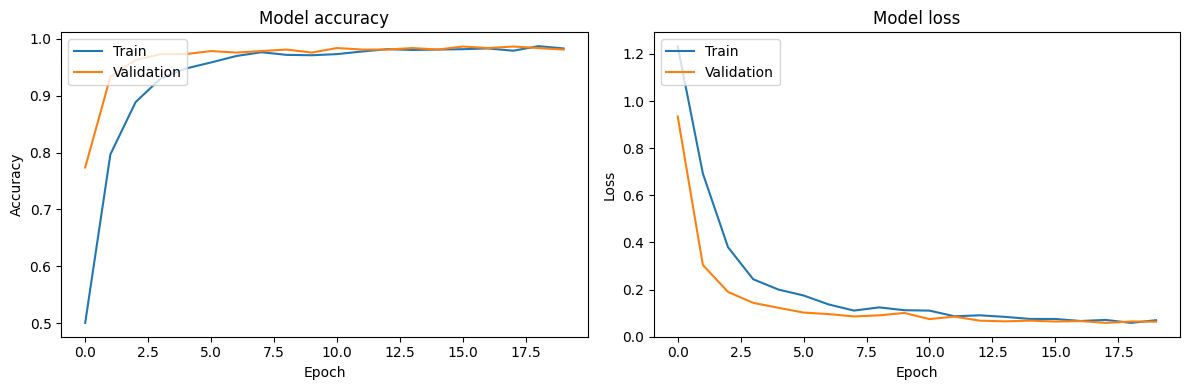

In [59]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_history(history)

### Step 7: Evaluating the Model

Now that the model is trained, we evaluate its final performance on the test set, which it has never seen before. We'll look at the overall loss and accuracy, and then dive deeper with a confusion matrix and a classification report.

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9768 - loss: 0.0727

Test Accuracy: 0.9766
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Classification Report:


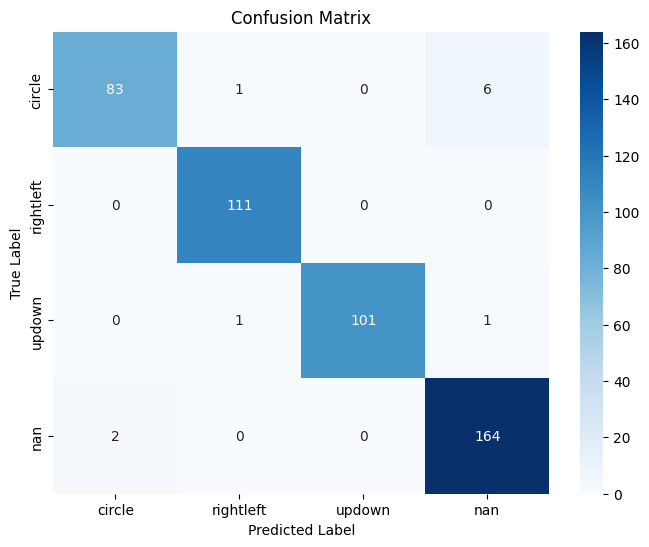

In [60]:
# Evaluate on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\nClassification Report:")
class_names = [label_mapping[i] for i in range(num_classes)]
# print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Step 8: Converting to TensorFlow Lite

Now we convert our trained Keras model into the TensorFlow Lite format. This creates a highly optimized and lightweight model file (`.tflite`) suitable for deployment on microcontrollers.

In [61]:
# Convert the model to the TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to a file
with open('gesture_model.tflite', 'wb') as f:
    f.write(tflite_model)

print(f"Model converted and saved as gesture_model.tflite")
print(f"Size of TFLite model: {len(tflite_model) / 1024:.2f} KB")

Saved artifact at '/tmp/tmpi4bfv5j5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 6, 1), dtype=tf.float32, name='keras_tensor_55')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138301242944272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138301242942736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138301242935440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138300158675664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138300158674320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138300158674512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138300158673360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138300158674704: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model converted and saved as gesture_model.tflite
Size of TFLite model: 120.06 KB


### Step 9: Generating the C Header File

The final step is to convert the binary `.tflite` model into a C-style byte array that can be compiled into our embedded application. We will create a C header file (`gesture_model.h`) containing this byte array.

In [62]:
# --- Configuration ---
# Define the base name for our model files and variables.
# This makes it easy to adapt for other models in the future.
MODEL_BASENAME = "gesture_recognition_model"

# --- Derived Names ---
# Automatically generate the filenames and variable names based on the base name.
HEADER_FILENAME = f"{MODEL_BASENAME}_data.h"
SOURCE_FILENAME = f"{MODEL_BASENAME}_data.cpp"
VAR_NAME = f"g_{MODEL_BASENAME}_data"
HEADER_GUARD = f"TENSORFLOW_LITE_MICRO_EXAMPLES_{MODEL_BASENAME.upper()}_DATA_H_"

# --- 1. Generate the C++ Source File (.cpp) ---
# This file defines the actual model data and its length.

def model_bytes_to_c_array(bytes_data, var_name="g_model"):
    """
    Takes a byte array and converts it into a C-style char array string,
    matching the formatting of the TensorFlow Lite examples.
    """
    hex_array = [f'0x{b:02x}' for b in bytes_data]
    c_code = f'// Keep aligned to 16 bytes for CMSIS-NN performance\n'
    c_code += f'alignas(16) const unsigned char {var_name}[] = {{\n'
    # Format into lines of 12 bytes
    for i in range(0, len(hex_array), 12):
        line = ', '.join(hex_array[i:i+12])
        c_code += f'  {line},\n'
    c_code = c_code.rstrip(',\n') + '\n' # Remove trailing comma
    c_code += '};\n'
    return c_code

# Generate the C array string from our tflite_model byte array
c_array_string = model_bytes_to_c_array(tflite_model, VAR_NAME)

# Assemble the full content for the .cpp file using the reference style
source_file_content = f"""/* Copyright 2024 The TensorFlow Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
==============================================================================*/

/*
 * This file contains the raw data for the gesture recognition model.
 * It is quantized and converted to a C-style array by a Python script,
 * similar to the 'xxd' tool used in the official examples.
 */

#include "{HEADER_FILENAME}"

{c_array_string}
// The length of the model array, used by the TFLite interpreter.
const int {VAR_NAME}_len = {len(tflite_model)};
"""

# Write the content to the .cpp file
with open(SOURCE_FILENAME, 'w') as f:
    f.write(source_file_content)

print(f"Successfully generated source file: {SOURCE_FILENAME}")


# --- 2. Generate the C++ Header File (.h) ---
# This file declares the variables, making them accessible to other parts of your code.

header_file_content = f"""/* Copyright 2024 The TensorFlow Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
==============================================================================*/

/*
 * This file contains the declarations for the gesture recognition model.
 * It is intended to be included by the main C++ application.
 */

#ifndef {HEADER_GUARD}
#define {HEADER_GUARD}

// The 'extern' keyword tells the compiler that these variables are defined
// in another file (in our case, {SOURCE_FILENAME}). This allows any file
// that includes this header to use these variables without causing a linker error.
extern const unsigned char {VAR_NAME}[];
extern const int {VAR_NAME}_len;

#endif // {HEADER_GUARD}
"""

# Write the content to the .h file
with open(HEADER_FILENAME, 'w') as f:
    f.write(header_file_content)

print(f"Successfully generated header file: {HEADER_FILENAME}")

# --- 3. (Optional) Display a snippet of the generated files for verification ---
print(f"\n--- Snippet of {SOURCE_FILENAME}: ---")
print('\n'.join(source_file_content.splitlines()[:20]))
print("...")

print(f"\n--- Content of {HEADER_FILENAME}: ---")
print(header_file_content)

Successfully generated source file: gesture_recognition_model_data.cpp
Successfully generated header file: gesture_recognition_model_data.h

--- Snippet of gesture_recognition_model_data.cpp: ---
/* Copyright 2024 The TensorFlow Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
==============================================================================*/

/*
 * This file contains the raw data for the gesture recognition model.
 * It is quantized and converted to a C-style array by a Pyth

In [ ]:
print("--- COPY THESE VALUES INTO YOUR ARDUINO SKETCH ---")
print("// StandardScaler Mean values for [ax, ay, az, gx, gy, gz]")
print("const float SCALER_MEAN[kNumFeatures] = {", ", ".join(f"{v:.8f}f" for v in scaler.mean_), "};")
print("\n// StandardScaler Standard Deviation values for [ax, ay, az, gx, gy, gz]")
print("const float SCALER_STD[kNumFeatures] = {", ", ".join(f"{v:.8f}f" for v in scaler.scale_), "};")

--- COPY THESE VALUES INTO YOUR ARDUINO SKETCH ---
// StandardScaler Mean values for [ax, ay, az, gx, gy, gz]
const float SCALER_MEAN[kNumFeatures] = { -0.00144222f, 0.00294193f, 0.00477476f, 10.41929488f, 2.59923357f, -0.33165602f };

// StandardScaler Standard Deviation values for [ax, ay, az, gx, gy, gz]
const float SCALER_STD[kNumFeatures] = { 0.43019883f, 0.68843083f, 0.92744974f, 83.66129046f, 153.65546148f, 120.49392109f };


### Conclusion and Next Steps

Congratulations! You have successfully trained a gesture recognition model and converted it into a C header file for an embedded device.

**To use this in a project (e.g., Arduino):**
1. Add the `gesture_model.h` file to your project's directory.
2. In your main sketch, include the header: `#include "gesture_model.h"`.
3. Load the model into the TensorFlow Lite for Microcontrollers interpreter using the `g_gesture_model` array and `g_gesture_model_len` variable.
4. In your `loop()`, collect 50 samples of sensor data, just like the sequences we created here.
5. **Crucially**, you must apply the **same scaling** to your live sensor data that you used for training. You will need to hard-code the means and standard deviations from the `StandardScaler` into your device code.
6. Feed the preprocessed sequence into the interpreter to get a prediction.
7. Map the prediction index back to a gesture label using the `label_mapping` we printed earlier.